# Decision Tree

## Import Library

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from Utils import plot_corrlation_heatmap, plotMetricsGraphComparison

## Import Train and Test Datasets

In [3]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [191]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Classification Model": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [192]:
# Set up a dataframe to store the results from different versions
train_metrics_dt = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics_dt = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Feature Selection for Decision Tree

Decision tree inherently performs feature selection as part of its model training process. In scikit-learn, the feature importance provided by decision tree-based models is based on the Gini importance. Gini importance measures the total decrease in node impurity (often quantified using the Gini index) weighted by the probability of reaching that node during the construction of the decision tree.

### Decision Tree with all features

**Training Set Metrics**
Accuracy 	: 0.9918595527657905
Precision 	: 0.9957493080268881
Recall 		: 0.9879364456649666
F1 Score 	: 0.9918274911382434

**Test Set Metrics**
Accuracy 	: 0.7531800391389433
Precision 	: 0.41707798617966435
Recall 		: 0.5023781212841855
F1 Score 	: 0.45577130528586834


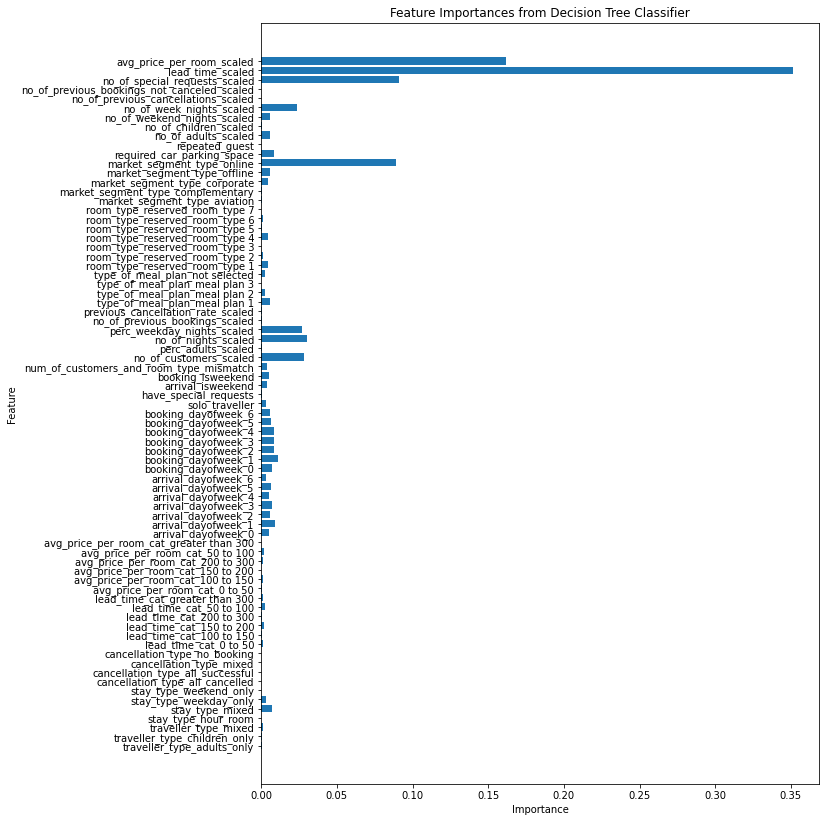

In [193]:
from sklearn.tree import DecisionTreeClassifier
# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=47)

# Train the decision tree classifier on the training data
tree_clf.fit(X_train, Y_train)

# Make predictions on the testing data
Y_train_pred = tree_clf.predict(X_train)
Y_test_pred = tree_clf.predict(X_test)

train_metrics_dt, test_metrics_dt = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "With Feature Engineering", train_metrics_dt, test_metrics_dt)

# Get feature importances
feature_importances = tree_clf.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 14))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=X_train.columns)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.show()

### Decision tree with top n features

Best set of features: Index(['lead_time_scaled', 'avg_price_per_room_scaled',
       'no_of_special_requests_scaled', 'market_segment_type_online',
       'no_of_nights_scaled', 'no_of_customers_scaled',
       'perc_weekday_nights_scaled', 'no_of_week_nights_scaled',
       'booking_dayofweek_1', 'arrival_dayofweek_1', 'booking_dayofweek_3',
       'required_car_parking_space', 'booking_dayofweek_2',
       'booking_dayofweek_4', 'arrival_dayofweek_3', 'stay_type_mixed',
       'booking_dayofweek_0', 'booking_dayofweek_5', 'arrival_dayofweek_5',
       'no_of_adults_scaled', 'market_segment_type_offline',
       'booking_dayofweek_6', 'no_of_weekend_nights_scaled',
       'arrival_dayofweek_2'],
      dtype='object')
Number of features: 24
Best F1 score: 0.47669773635153123


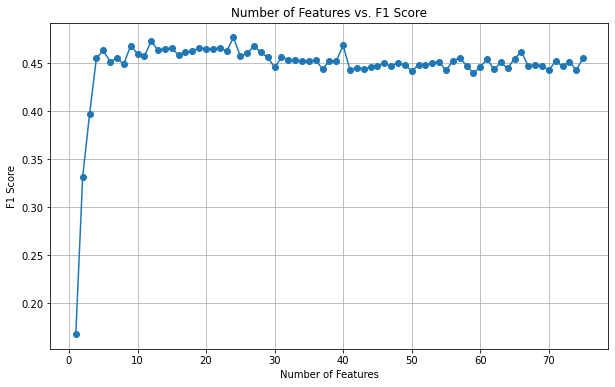

In [36]:
# Initialize variables to store the best F1 score and corresponding set of features
best_f1_score = 0
best_num_features = 0
best_feature_set_1 = []

# Initialize lists to store the F1 scores and the number of features
f1_scores = []
num_features_selected = []

# Sort feature importances in descending order
sorted_indices = (-feature_importances).argsort()

# Train the decision tree classifier on subsets of features
for i in range(1, len(X_train.columns) + 1):
    # Select top 'i' features based on sorted indices
    top_features = X_train.columns[sorted_indices[:i]]
    tree_clf = DecisionTreeClassifier(random_state=47)
    tree_clf.fit(X_train[top_features], Y_train)
    
    # Make predictions on the test dataset
    Y_test_pred = tree_clf.predict(X_test[top_features])
    
    # Calculate the F1 score
    f1 = f1_score(Y_test, Y_test_pred)
    
    # Update the best F1 score and corresponding set of features if necessary
    if f1 > best_f1_score:
        best_f1_score = f1
        best_num_features = i
        best_feature_set_1 = top_features
    
    # Append the F1 score and the number of features selected
    f1_scores.append(f1)
    num_features_selected.append(i)

# Plot the number of features vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, f1_scores, marker='o', linestyle='-')
plt.title('Number of Features vs. F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.grid(True)

# Print the best set of features and the corresponding number of features
print("Best set of features:", best_feature_set_1)
print("Number of features:", best_num_features)
print("Best F1 score:", best_f1_score)

plt.show()


### Run model with selected features

In [195]:
tree_clf_selected = DecisionTreeClassifier(random_state=47)

# Train the decision tree classifier on the training data
tree_clf_selected.fit(X_train[best_feature_set_1], Y_train)

# Make predictions on the testing data
Y_train_pred_selected = tree_clf_selected.predict(X_train[best_feature_set_1])
Y_test_pred_selected = tree_clf_selected.predict(X_test[best_feature_set_1])

train_metrics_dt, test_metrics_dt = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics_dt, test_metrics_dt)

**Training Set Metrics**
Accuracy 	: 0.9914182032169478
Precision 	: 0.9953534354918437
Recall 		: 0.9874460572773637
F1 Score 	: 0.9913839791246123

**Test Set Metrics**
Accuracy 	: 0.7596624266144814
Precision 	: 0.43174143753014954
Recall 		: 0.5321046373365041
F1 Score 	: 0.47669773635153123


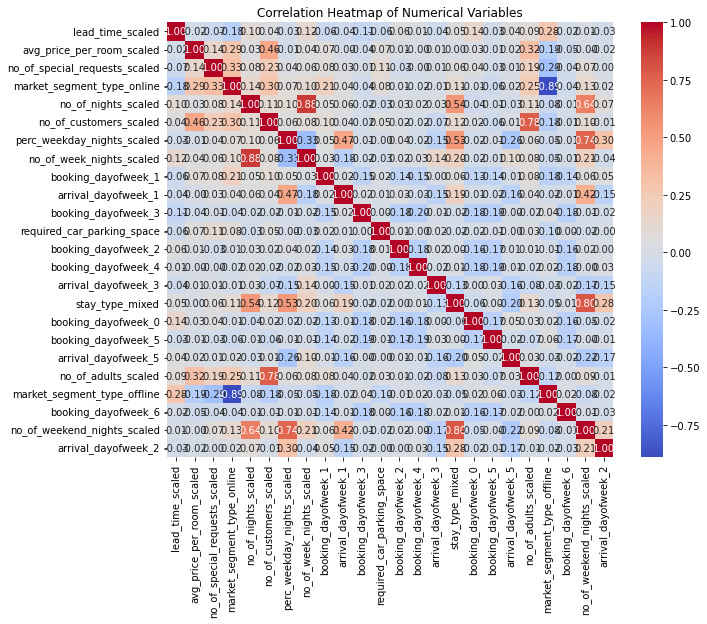

In [52]:
# Assuming df is your DataFrame and best_feature_set_1 is the list of features
plot_corrlation_heatmap(X_train[best_feature_set_1])

In [157]:
col_to_remove = ['market_segment_type_offline','no_of_weekend_nights_scaled','no_of_adults_scaled']
best_feature_set_1_filtered = [col for col in best_feature_set_1 if col not in col_to_remove]

In [158]:
best_feature_set_1_filtered

['lead_time_scaled',
 'avg_price_per_room_scaled',
 'no_of_special_requests_scaled',
 'market_segment_type_online',
 'no_of_nights_scaled',
 'no_of_customers_scaled',
 'perc_weekday_nights_scaled',
 'no_of_week_nights_scaled',
 'booking_dayofweek_1',
 'arrival_dayofweek_1',
 'booking_dayofweek_3',
 'required_car_parking_space',
 'booking_dayofweek_2',
 'booking_dayofweek_4',
 'arrival_dayofweek_3',
 'stay_type_mixed',
 'booking_dayofweek_0',
 'booking_dayofweek_5',
 'arrival_dayofweek_5',
 'booking_dayofweek_6',
 'arrival_dayofweek_2']

In [196]:
tree_clf_final_selected = DecisionTreeClassifier(random_state=47)

# Train the decision tree classifier on the training data
tree_clf_final_selected.fit(X_train[best_feature_set_1_filtered], Y_train)

# Make predictions on the testing data
Y_train_pred_final_selected = tree_clf_final_selected.predict(X_train[best_feature_set_1_filtered])
Y_test_pred_final_selected = tree_clf_final_selected.predict(X_test[best_feature_set_1_filtered])

train_metrics_dt, test_metrics_dt = evaluate(Y_train, Y_train_pred_final_selected, Y_test, Y_test_pred_final_selected, "Final Feature Selected", train_metrics_dt, test_metrics_dt)

**Training Set Metrics**
Accuracy 	: 0.9914182032169478
Precision 	: 0.9953534354918437
Recall 		: 0.9874460572773637
F1 Score 	: 0.9913839791246123

**Test Set Metrics**
Accuracy 	: 0.7583170254403131
Precision 	: 0.42891682785299806
Recall 		: 0.5273483947681332
F1 Score 	: 0.47306666666666675


## Permutation Importance

It assesses the impact of shuffling or permuting the values of individual features on the model's performance. 

In [71]:
from sklearn.inspection import permutation_importance

# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=47)

# Train the decision tree classifier on the training data
tree_clf.fit(X_train, Y_train)

# Perform permutation importance
perm_importance = permutation_importance(tree_clf, X_test, Y_test, n_repeats=10, random_state=47,scoring='f1')

# Get feature importances from permutation importance
feature_importances_perm = perm_importance.importances_mean

In [72]:
# Print features and their importances
for i, (feature, importance) in enumerate(zip(X_train.columns, feature_importances_perm)):
    print(f"Feature {i+1}: {feature}, Importance: {importance}")

Feature 1: traveller_type_adults_only, Importance: 0.0012530227214682388
Feature 2: traveller_type_children_only, Importance: -0.0003330770978084097
Feature 3: traveller_type_mixed, Importance: 4.9160924718594236e-05
Feature 4: stay_type_hour_room, Importance: 0.0
Feature 5: stay_type_mixed, Importance: 0.01575049382538532
Feature 6: stay_type_weekday_only, Importance: -0.0009456800778526508
Feature 7: stay_type_weekend_only, Importance: -4.9179531188126015e-05
Feature 8: cancellation_type_all_cancelled, Importance: 0.0
Feature 9: cancellation_type_all_successful, Importance: 0.00011059427736778704
Feature 10: cancellation_type_mixed, Importance: 0.0
Feature 11: cancellation_type_no_booking, Importance: 0.0
Feature 12: lead_time_cat_0 to 50, Importance: 0.0033153320285020326
Feature 13: lead_time_cat_100 to 150, Importance: -0.0002487739323202676
Feature 14: lead_time_cat_150 to 200, Importance: -0.0002157578900179924
Feature 15: lead_time_cat_200 to 300, Importance: 0.0
Feature 16: le

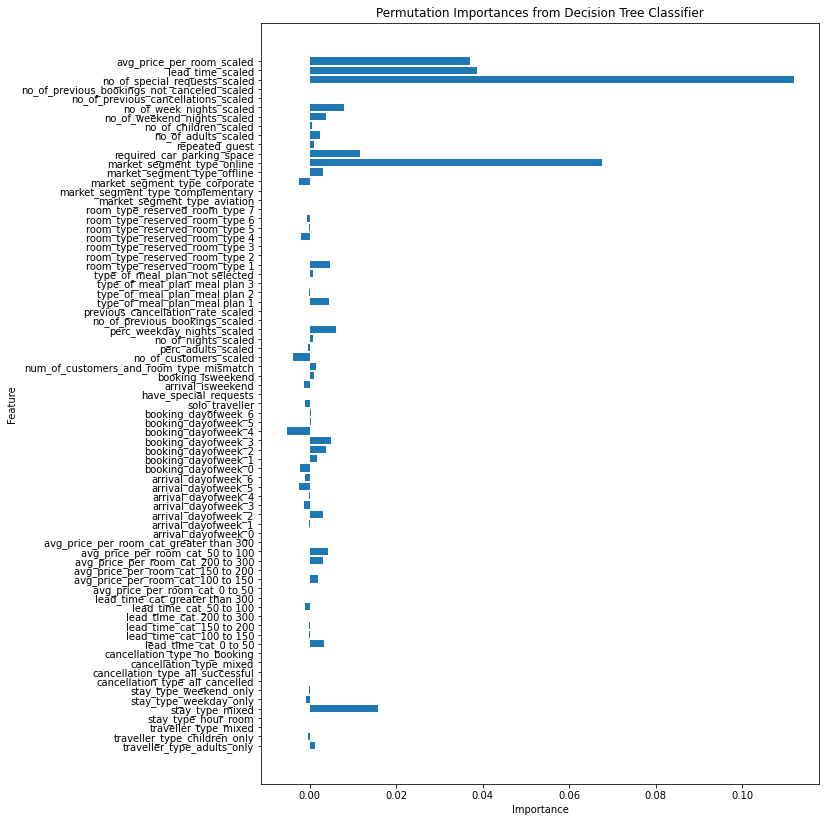

In [73]:
# Plot feature importances
plt.figure(figsize=(10, 14))
plt.barh(range(len(feature_importances_perm)), feature_importances_perm, tick_label=X_train.columns)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances from Decision Tree Classifier')
plt.show()

Negative permutation importance values indicate that shuffling a particular feature's values doesn't harm the model's performance, or in some cases, it might even improve it. This can happen if the feature is noisy or not informative for predicting the target variable.

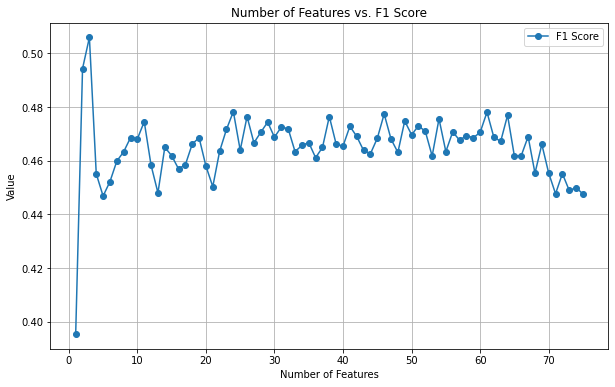

Best set of features: Index(['no_of_special_requests_scaled', 'market_segment_type_online',
       'lead_time_scaled'],
      dtype='object')
Number of features: 3
Best F1 score: 0.505916213623281


In [74]:
# Initialize variables to store the best F1 score and corresponding set of features
best_f1_score = 0
best_num_features = 0
best_feature_set_2 = []

# Initialize lists to store the F1 scores, the number of features, and the feature importances
f1_scores = []
num_features_selected = []

# Sort feature importances in descending order
sorted_indices = (-feature_importances_perm).argsort()

# Train the decision tree classifier on subsets of features
for i in range(1, len(X_train.columns) + 1):
    # Select top 'i' features based on sorted indices
    top_features = X_train.columns[sorted_indices[:i]]
    tree_clf = DecisionTreeClassifier(random_state=47)
    tree_clf.fit(X_train[top_features], Y_train)
    
    # Make predictions on the test dataset
    Y_test_pred = tree_clf.predict(X_test[top_features])
    
    # Calculate the F1 score
    f1 = f1_score(Y_test, Y_test_pred)
    
    # Update the best F1 score and corresponding set of features if necessary
    if f1 > best_f1_score:
        best_f1_score = f1
        best_num_features = i
        best_feature_set_2 = top_features
    
    # Append the F1 score and the number of features selected
    f1_scores.append(f1)
    num_features_selected.append(i)

# Plot the number of features vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, f1_scores, marker='o', linestyle='-', label='F1 Score')

plt.title('Number of Features vs. F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# Print the best set of features and the corresponding number of features
print("Best set of features:", best_feature_set_2)
print("Number of features:", best_num_features)
print("Best F1 score:", best_f1_score)

## Hyperparameter Tuning with Best Set of Features

For DecisionTreeClassifier, the following hyperparameters can be tuned:

1. max_depth (default=None): The maximum depth of the tree. It limits the number of nodes in the tree and helps control overfitting.

2. min_samples_split (default=2): The minimum number of samples required to split an internal node. Increasing this value can prevent overfitting by ensuring that each split contains enough samples.

3. min_samples_leaf (default=1): The minimum number of samples required to be at a leaf node. This parameter controls the minimum size of the leaves and can help prevent overfitting.

4. max_features (default=None): The number of features to consider when looking for the best split. It can be set to 'auto', 'sqrt', 'log2', or an integer value. This parameter can also help control overfitting by limiting the number of features considered at each split.

5. criterion (default='gini'): The function to measure the quality of a split. It can be either 'gini' for the Gini impurity or 'entropy' for the information gain. The default is 'gini', but 'entropy' can be used if you prefer information gain.

6. splitter (default='best'): The strategy used to choose the split at each node. It can be either 'best' to choose the best split or 'random' to choose the best random split. The default is 'best', but 'random' can sometimes improve performance, especially with noisy data.

best_feature_set_1_filtered was chosen because it contains more information compared to best_feature_set_2, which only consists of three features. Additionally, it underwent a process where features with high correlations were removed.

In [169]:
best_feature_set_1_filtered

['lead_time_scaled',
 'avg_price_per_room_scaled',
 'no_of_special_requests_scaled',
 'market_segment_type_online',
 'no_of_nights_scaled',
 'no_of_customers_scaled',
 'perc_weekday_nights_scaled',
 'no_of_week_nights_scaled',
 'booking_dayofweek_1',
 'arrival_dayofweek_1',
 'booking_dayofweek_3',
 'required_car_parking_space',
 'booking_dayofweek_2',
 'booking_dayofweek_4',
 'arrival_dayofweek_3',
 'stay_type_mixed',
 'booking_dayofweek_0',
 'booking_dayofweek_5',
 'arrival_dayofweek_5',
 'booking_dayofweek_6',
 'arrival_dayofweek_2']

#### Tune max_depth

In [65]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for max_depth
parameters_max_depth = {
    'max_depth': range(5, 16) 
}

# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=47)

# Initialize GridSearchCV with the parameter grid, cross-validation, and scoring
grid_search_max_depth = GridSearchCV(tree_clf, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)

# Perform grid search
grid_search_max_depth.fit(X_train[best_feature_set_1_filtered], Y_train.values.ravel())

# Print the best parameters and score
print("Best max_depth:", grid_search_max_depth.best_params_)
print("Best F1 Score:", grid_search_max_depth.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best max_depth: {'max_depth': 13}
Best F1 Score: 0.8616452366609602


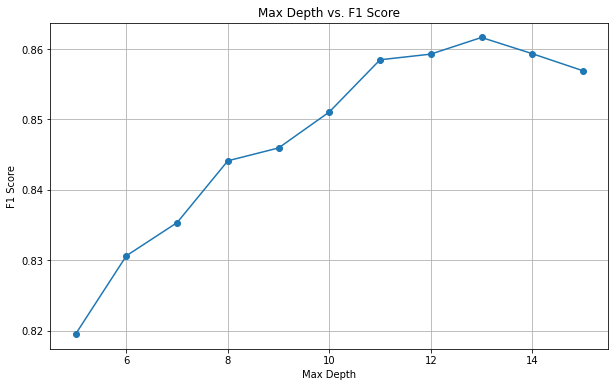

In [66]:
# Extract max_depth values and corresponding F1 scores
max_depth_values = [params['max_depth'] for params in grid_search_max_depth.cv_results_['params']]
f1_scores = grid_search_max_depth.cv_results_['mean_test_score']

# Plot max_depth vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, f1_scores, marker='o', linestyle='-')
plt.title('Max Depth vs. F1 Score')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

 We will minimise the range for  max_depth to (10, 15) for the following tuning.

#### Tune max_features

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the parameter grid for max_features
parameters_max_features = {
    'max_features': ['sqrt', 'log2', None] + list(range(1, X_train.shape[1] + 1)) 
}

# Initialize GridSearchCV for max_features
grid_search_max_features = GridSearchCV(tree_clf, param_grid=parameters_max_features, cv=5, scoring='f1', verbose=1)

# Perform grid search for max_features
grid_search_max_features.fit(X_train[best_feature_set_1_filtered], Y_train.values.ravel())

# Get the best parameters and scores
best_max_features = grid_search_max_features.best_params_
best_f1_score = grid_search_max_features.best_score_

# Extract max_features values and corresponding F1 scores
max_features_values = [params['max_features'] for params in grid_search_max_features.cv_results_['params']]
f1_scores_max_features = grid_search_max_features.cv_results_['mean_test_score']

Fitting 5 folds for each of 78 candidates, totalling 390 fits


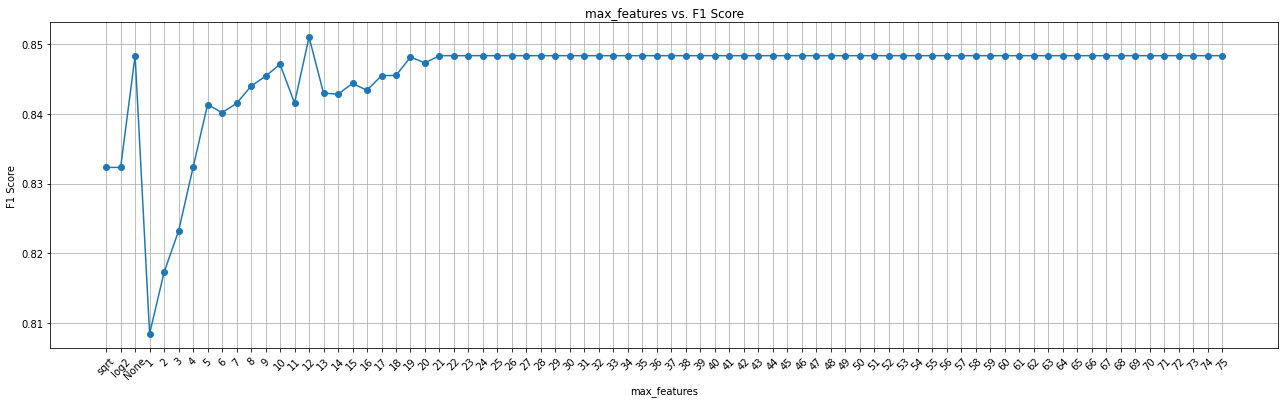

Best max_features: {'max_features': 12}
Best F1 Score for max_features: 0.851002504925756


In [116]:
# Plot max_features vs. F1 score
max_features_values = ['None' if x is None else x for x in max_features_values]
plt.figure(figsize=(22, 6))
plt.plot(max_features_values, f1_scores_max_features, marker='o', linestyle='-')
plt.title('max_features vs. F1 Score')
plt.xlabel('max_features')
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# Print the best parameters and score
print("Best max_features:", best_max_features)
print("Best F1 Score for max_features:", best_f1_score)

We will minimise the range for adopt max_features to [12, 19, 22, None] for the following tuning.

#### Tune min_samples_split and min_samples_leaf

Fitting 5 folds for each of 90 candidates, totalling 450 fits


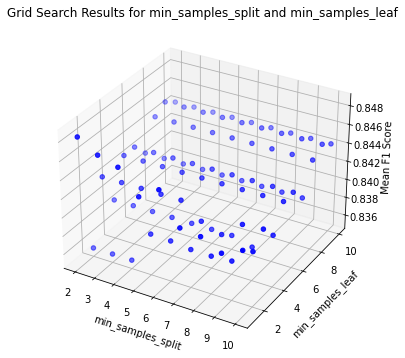

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid for min_samples_split and min_samples_leaf
parameters = {
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11)
}

# Initialize GridSearchCV with the parameter grid, cross-validation, and scoring
grid_search = GridSearchCV(tree_clf, param_grid=parameters, cv=5, scoring='f1', verbose=1)

# Perform grid search
grid_search.fit(X_train[best_feature_set_1_filtered], Y_train.values.ravel())

# Extract results
mean_scores = grid_search.cv_results_['mean_test_score']
split_values = [param['min_samples_split'] for param in grid_search.cv_results_['params']]
leaf_values = [param['min_samples_leaf'] for param in grid_search.cv_results_['params']]

# Plot results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of min_samples_split, min_samples_leaf, and F1 score
ax.scatter(split_values, leaf_values, mean_scores, c='b', marker='o')

# Set labels and title
ax.set_xlabel('min_samples_split')
ax.set_ylabel('min_samples_leaf')
ax.set_zlabel('Mean F1 Score')
ax.set_title('Grid Search Results for min_samples_split and min_samples_leaf')

plt.show()

In [87]:
# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters:")
print(f"min_samples_split: {best_params['min_samples_split']}")
print(f"min_samples_leaf: {best_params['min_samples_leaf']}")

Best parameters:
min_samples_split: 2
min_samples_leaf: 1


Smaller min_samples_split and min_samples_leaf tend to result in higher performance. Hence, we will use smaller numbers for the below tuning.

### Tune hyperparameters again with smaller ranges

In [117]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
parameters = {
    'max_depth': range(10, 16), 
    'max_features': [12, 19, 22, None],  
    'criterion': ['gini', 'entropy'],  
    'splitter': ['best', 'random'],  
    'min_samples_split': range(2, 4), 
    'min_samples_leaf': range(1, 4) 
}

# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=47)

# Initialize GridSearchCV with the parameter grid, cross-validation, and scoring
grid_search = GridSearchCV(tree_clf, param_grid=parameters, cv=5, scoring='f1', verbose=1)

# Perform grid search
grid_search.fit(X_train[best_feature_set_1_filtered], Y_train.values.ravel())

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best F1 Score:", best_score)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
Best F1 Score: 0.866055356537729


### Fit model again with the best parameters

In [197]:
tree_clf_tuned = DecisionTreeClassifier(
    criterion= 'entropy', max_depth= 14, max_features= 22, min_samples_leaf= 1, min_samples_split= 3, splitter= 'best',
    random_state=47
).fit(X_train[best_feature_set_1_filtered], Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_tuned = tree_clf_tuned.predict(X_train[best_feature_set_1_filtered])
Y_test_pred_tuned = tree_clf_tuned.predict(X_test[best_feature_set_1_filtered])

train_metrics_dt, test_metrics_dt = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics_dt, test_metrics_dt)

**Training Set Metrics**
Accuracy 	: 0.9086896822283248
Precision 	: 0.9216757741347905
Recall 		: 0.8932914868575912
F1 Score 	: 0.9072616794501444

**Test Set Metrics**
Accuracy 	: 0.8044275929549902
Precision 	: 0.525664811379097
Recall 		: 0.5053507728894173
F1 Score 	: 0.5153076689906031


In [201]:
# Exporting the best model to be compared later on
import joblib

joblib.dump(tree_clf_tuned, "FinalModels/BestDecisionTree.pkl") 

['FinalModels/BestDecisionTree.pkl']

In [204]:
# Create a DataFrame with column names from X_train
df_features = pd.DataFrame({'feature': X_train.columns})

# Add a column to indicate if the feature is in best_feature_set_1_filtered
df_features['selected'] = df_features['feature'].isin(best_feature_set_1_filtered)
df_features

,feature,selected
0,traveller_type_adults_only,False
1,traveller_type_children_only,False
2,traveller_type_mixed,False
3,stay_type_hour_room,False
4,stay_type_mixed,True
...,...,...
70,no_of_previous_cancellations_scaled,False
71,no_of_previous_bookings_not_canceled_scaled,False
72,no_of_special_requests_scaled,True
73,lead_time_scaled,True


In [205]:
# Exporting the features used for this model
from FeatureSelectionUtils import save_feature_data_to_csv

models_feature_data = [
    ("Decision Tree Embedded Feature Selection", df_features),
]

save_feature_data_to_csv(models_feature_data, "Best Decision Tree")

feature,Selection Name,arrival_dayofweek_0,arrival_dayofweek_1,arrival_dayofweek_2,arrival_dayofweek_3,arrival_dayofweek_4,arrival_dayofweek_5,arrival_dayofweek_6,arrival_isweekend,avg_price_per_room_cat_0 to 50,...,stay_type_mixed,stay_type_weekday_only,stay_type_weekend_only,traveller_type_adults_only,traveller_type_children_only,traveller_type_mixed,type_of_meal_plan_meal plan 1,type_of_meal_plan_meal plan 2,type_of_meal_plan_meal plan 3,type_of_meal_plan_not selected
0,Decision Tree Embedded Feature Selection,False,True,True,True,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


## Evaluation

In [189]:
test_metrics_dt

,Classification,Accuracy,Precision,Recall,F1 Score
0,With Feature Engineering,0.753180,0.417078,0.502378,0.455771
1,Feature Selected,0.759662,0.431741,0.532105,0.476698
2,Final Feature Selected,0.758317,0.428917,0.527348,0.473067
3,Hyperparameter Tuned,0.804428,0.525665,0.505351,0.515308


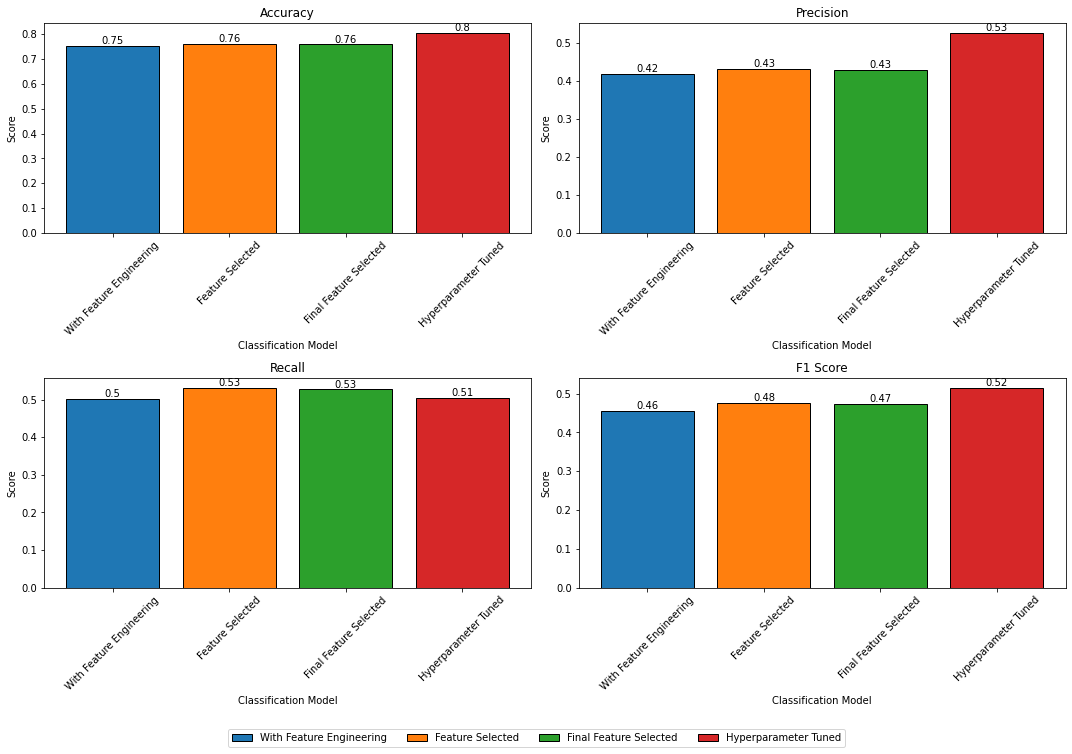

In [198]:
plotMetricsGraphComparison(test_metrics_dt)